# EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

C:\Users\pault\AppData\Local\Temp\ipykernel_20704\65909657.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv("card_credit_fraud.csv", delimiter=";", decimal=",")
df.head()

,transactionId,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


Notre Dataframe ne s'affiche pas correctement lorsqu'on utilise `df.head()`. Après inspection de notre CSV, il semblerait que le problème soit les guillemets entourant chacune des lignes du CSV. Nous pouvons donc retirer ces guillemets et voir ce que cela donne :

## Avant
![image.png](src/trouver_guillemets.png)

## Après
![image2.png](src/csv_sans_guillemet.png)


Notre Dataframe devrait maintenant s'afficher correctement :


In [3]:
df = pd.read_csv("card_credit_fraud.csv", delimiter=";", decimal=",")
df.head()

,transactionId,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


# Observation du dataframe

**Taille** : 1008213 lignes par 11 colonnes.

**Présence de valeur null** : Aucune valeur null

**Description de nos features** : 

| Colonne          | Description                                                                                                                |
|------------------|----------------------------------------------------------------------------------------------------------------------------|
| transactionId    | Sert d'index                                                                                                               |
| step             | Heure à laquelle la transaction s'est passée. Minimum = 1 Maximum = 743 ; 743 / 24 ~= 31                                |
| type             | Le type de la transaction. Peut prendre plusieurs valeurs sous forme de chaînes de caractères. Pour mapper les données, utiliser `LabelEncoder de sklearn.preprocessing` |
| amount           | Le montant de chaque transaction                                                                                          |
| nameOrig         | Numéro de compte de l'émetteur. Pour mapper les données, utiliser `LabelEncoder de sklearn.preprocessing`                                                                                            |
| oldbalanceOrg    | Solde de l'émetteur avant la transaction                                                                                   |
| newbalanceOrig    | Solde de l'émetteur après la transaction                                                                                   |
| nameDest         | Numéro de compte du destinataire. Pour mapper les données, utiliser `LabelEncoder de sklearn.preprocessing`                                                                                          |
| oldbalanceDest   | Solde du destinataire avant la transaction                                                                                 |
| newbalanceDest   | Solde du destinataire après la transaction                                                                                 |
| isFraud          | Notre cible, non fraude = 0 ; fraude = 1                                                                                   |



In [4]:
print("Taille du df : ", df.shape)
print()
print("Présence de valeur nul:", df.isnull().any())
print()
print("Valeur maximum dans step :", df["step"].max())
print()
print()

Taille du df :  (1008213, 11)

Présence de valeur nul: transactionId     False
step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
dtype: bool

Valeur maximum dans step : 743




## Visualisation de la répartition des données

Nous pouvons constater que notre dataset est grandement déséquilibré. 99,2% des data points ne sont pas des fraudes et seulement 0.08% constituent réellement des fraudes. un déséquilibre des classes risqueraient de biaiser l'entraînement des modèles et les prédictions qui en résulteront.

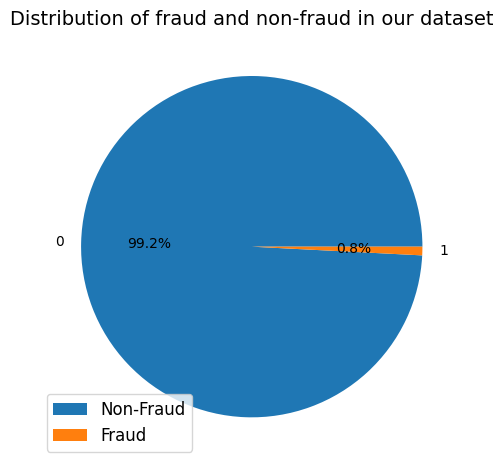

In [5]:
# Create the pie chart
plt.pie(df["isFraud"].value_counts(), labels=[0,1], autopct='%1.1f%%')

# Add a title and adjust the font size
plt.title('Distribution of fraud and non-fraud in our dataset', fontsize=14)

# Add a legend and adjust the font size
plt.legend(["Non-Fraud", "Fraud"], fontsize=12)

# Add some padding to the plot
plt.tight_layout()

# Display the plot
plt.show()


## Nettoyage des données

### Drop des datapoints dont le type est différents de "TRANSFER" ou "CASH_OUT"

Les valeurs que peuvent prendre certaines features dans nos datapoints semble optionnel à l'identification d'une fraude.

Comme on peut le constater ci-dessous, les data points qualifiés comme fraudes ont systématiquement comme valeurs pour la colonne ["type"] `TRANSFER` ou `CASH_OUT`. Toutes transactions qui n'est pas d'un de ces deux types ne peux pas être considéré comme une fraude. Nous pouvons donc retirer de notre df tout enregitrement dont la valeurs de ["type"] est différente de `TRANSFER` ou `CASH_OUT`.

Quantité de fraude / non fraude dans le df d'origine isFraud
0    444720
1      8213
Name: count, dtype: int64 Quantité de fraude / non fraude dans le df filtré avec transfer et cash_out :  isFraud
0    444720
1      8213
Name: count, dtype: int64


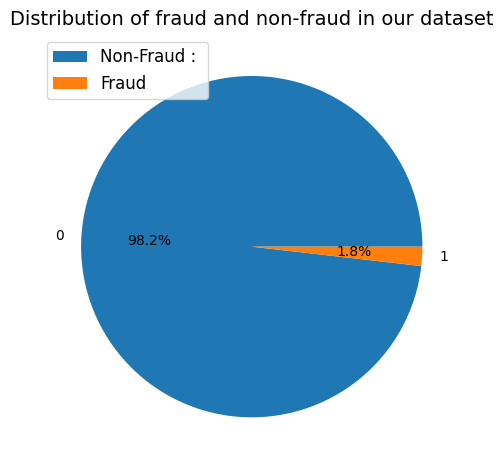

In [6]:
df = df[(df['type'] == "TRANSFER") | (df['type'] == "CASH_OUT")]

print("Quantité de fraude / non fraude dans le df d'origine", df["isFraud"].value_counts(), \
      ""
      "Quantité de fraude / non fraude dans le df filtré avec transfer et cash_out : " , df["isFraud"].value_counts())

# Create the pie chart
plt.pie(df["isFraud"].value_counts(), labels=[0,1], autopct='%1.1f%%')

# Add a title and adjust the font size
plt.title('Distribution of fraud and non-fraud in our dataset', fontsize=14)

# Add a legend and adjust the font size
plt.legend([f"Non-Fraud : ", "Fraud"], fontsize=12)

# Add some padding to the plot
plt.tight_layout()

# Display the plot
plt.show()

## Mappage des données et renommage
 

In [7]:
df.rename(columns= {"nameOrig" : "nameOrg", "newbalanceOrig" : "newbalanceOrg"}, inplace=True)

le = LabelEncoder()

df['type_encoded'] = le.fit_transform(df['type'])
df['nameOrg_encoded'] = le.fit_transform(df['nameOrg'])
df['nameDest_encoded'] = le.fit_transform(df['nameDest'])


df.drop(["type", "nameOrg", "nameDest"], inplace=True, axis=1)

df = df.reindex(columns=["transactionId", 
                        "step", 
                        "type_encoded", 
                        "amount", 
                        "nameOrg_encoded", 
                        "oldbalanceOrg", 
                        "newbalanceOrg", 
                        "nameDest_encoded", 
                        "oldbalanceDest", 
                        "newbalanceDest", 
                        "isFraud"
                        ])

In [8]:
df

,transactionId,step,type_encoded,amount,nameOrg_encoded,oldbalanceOrg,newbalanceOrg,nameDest_encoded,oldbalanceDest,newbalanceDest,isFraud
2,2,1,1,181.00,70896,181.00,0.0,69492,0.00,0.00,1
3,3,1,0,181.00,415365,181.00,0.0,61886,21182.00,0.00,1
15,15,1,0,229133.94,430382,15325.00,0.0,65923,5083.00,51513.44,0
19,19,1,1,215310.30,157010,705.00,0.0,4706,22425.00,0.00,0
24,24,1,1,311685.89,230295,10835.00,0.0,87415,6267.00,2719172.89,0
...,...,...,...,...,...,...,...,...,...,...,...
1008208,6362615,743,0,339682.13,402838,339682.13,0.0,79990,0.00,339682.13,1
1008209,6362616,743,1,6311409.28,123738,6311409.28,0.0,41126,0.00,0.00,1
1008210,6362617,743,0,6311409.28,38066,6311409.28,0.0,17001,68488.84,6379898.11,1
1008211,6362618,743,1,850002.52,160482,850002.52,0.0,50463,0.00,0.00,1


## Graphique de la nouvelle distribution des données

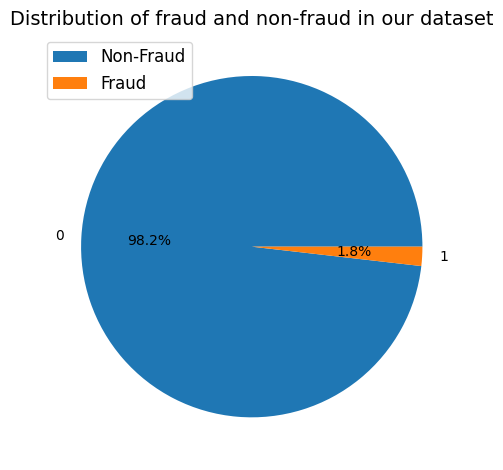

In [9]:
# Create the pie chart
plt.pie(df["isFraud"].value_counts(), labels=[0,1], autopct='%1.1f%%')

# Add a title and adjust the font size
plt.title('Distribution of fraud and non-fraud in our dataset', fontsize=14)

# Add a legend and adjust the font size
plt.legend(["Non-Fraud", "Fraud"], fontsize=12)

# Add some padding to the plot
plt.tight_layout()

# Display the plot
plt.show()

## En résumé

**Taille** : 452933 lignes par 11 colonnes.

**Présence de valeur null** : Aucune valeur null

**Description de nos features** : 

| Colonne          | Description                                                                                                                |
|------------------|----------------------------------------------------------------------------------------------------------------------------|
| transactionId    | Sert d'index                                                                                                               |
| step             | Heure à laquelle la transaction s'est passée. Minimum = 1 Maximum = 743 ; 743 / 24 ~= 31                                |
| type_encoded             | Le type de la transaction. Peut prendre plusieurs valeurs sous forme de chaînes de caractères. Données mappée avec `LabelEncoder de sklearn.preprocessing` |
| amount           | Le montant de chaque transaction                                                                                          |
| nameOrig_encoded         | Numéro de compte de l'émetteur. Données mappée avec `LabelEncoder de sklearn.preprocessing`                                                                                            |
| oldbalanceOrg    | Solde de l'émetteur avant la transaction                                                                                   |
| newbalanceOrig    | Solde de l'émetteur après la transaction                                                                                   |
| nameDest_encoded         | Numéro de compte du destinataire. Données mappée avec `LabelEncoder de sklearn.preprocessing`                                                                                          |
| oldbalanceDest   | Solde du destinataire avant la transaction                                                                                 |
| newbalanceDest   | Solde du destinataire après la transaction                                                                                 |
| isFraud          | Notre cible, non fraude = 0 ; fraude = 1                                                                                   |

![image.png](src/distribution_class_dataset_filtrer_transfer_cashout.png)


# Entraînement des modèles

Plan :

train_test_split

for each models :

    train with no over/undersampling 

    train using Nearmiss
    
    train using smote








In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [11]:
df

,transactionId,step,type_encoded,amount,nameOrg_encoded,oldbalanceOrg,newbalanceOrg,nameDest_encoded,oldbalanceDest,newbalanceDest,isFraud
2,2,1,1,181.00,70896,181.00,0.0,69492,0.00,0.00,1
3,3,1,0,181.00,415365,181.00,0.0,61886,21182.00,0.00,1
15,15,1,0,229133.94,430382,15325.00,0.0,65923,5083.00,51513.44,0
19,19,1,1,215310.30,157010,705.00,0.0,4706,22425.00,0.00,0
24,24,1,1,311685.89,230295,10835.00,0.0,87415,6267.00,2719172.89,0
...,...,...,...,...,...,...,...,...,...,...,...
1008208,6362615,743,0,339682.13,402838,339682.13,0.0,79990,0.00,339682.13,1
1008209,6362616,743,1,6311409.28,123738,6311409.28,0.0,41126,0.00,0.00,1
1008210,6362617,743,0,6311409.28,38066,6311409.28,0.0,17001,68488.84,6379898.11,1
1008211,6362618,743,1,850002.52,160482,850002.52,0.0,50463,0.00,0.00,1


In [12]:
# features
X = df[['step', 'type_encoded', 'amount', "nameOrg_encoded" ,'oldbalanceOrg', 'newbalanceOrg', "nameDest_encoded", 'oldbalanceDest', 'newbalanceDest']]

# target
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Regression logistique

### Sans over/under sampling
#### Features scaling

In [14]:
from sklearn.preprocessing import StandardScaler

# Création d'une fonction pour mettre à l'échelle notre df
def Standard_Scaler (df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features
    
    return df

col_names = ["step", "amount", "oldbalanceOrg", "newbalanceOrg", "oldbalanceDest", "newbalanceDest"]
X_train = Standard_Scaler (X_train, col_names)
X_test = Standard_Scaler (X_test, col_names)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


# Pour s'assurer que le grid search préserve le pourcentage de chaque classe lors du split
kf = StratifiedKFold(n_splits=5, shuffle=False)

logistic_regression_model = LogisticRegression(random_state=42)
param_logistic_regression = {
    "max_iter" : [10000],
    "penalty" : ["l2", None],
    "solver" : ["saga"]
}

grid_search = GridSearchCV(logistic_regression_model, param_grid=param_logistic_regression, cv=kf, scoring='recall', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


KeyboardInterrupt: 

In [ ]:
score = cross_val_score(logistic_regression_model, X_train, y_train, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))


### Avec undersampling (Nearmiss)

In [ ]:
from imblearn.under_sampling import NearMiss
from collections import Counter

nm = NearMiss()

X_near_miss, y_near_miss = nm.fit_resample(X_train, y_train)

print('Original dataset shape:', Counter(y))
print('Resample dataset shape:', Counter(y_near_miss))

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

logistic_regression_model_nearmiss = LogisticRegression(random_state=42)
param_logistic_regression = {
    "max_iter" : [100000],
    "penalty" : ["l2", None],
    "class_weight" : ["balanced", None],
    "solver" : ["saga"]

}

grid_search = GridSearchCV(logistic_regression_model, param_grid=param_logistic_regression, cv=kf, scoring='recall', verbose=2, n_jobs=-1)
grid_search.fit(X_near_miss, y_near_miss)

### Avec oversampling (SMOTE)

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter


sm = SMOTE(random_state=42, k_neighbors=5, n_jobs=-1) # 

X_smote, y_smote = sm.fit_resample(X_train, y_train)

print('Original dataset shape:', Counter(y))
print('Resample dataset shape:', Counter(y_smote))

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

logistic_regression_model_nearmiss = LogisticRegression(random_state=42)
param_logistic_regression = {
    "max_iter" : [100000],
    "penalty" : ["l2", None],
    "class_weight" : ["balanced", None],
    "solver" : ["saga"]

}

grid_search = GridSearchCV(logistic_regression_model, param_grid=param_logistic_regression, cv=kf, scoring='recall', verbose=2, n_jobs=-1)
grid_search.fit(X_smote, y_smote)